In [1]:
import os
import os.path as op
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import scipy
import mne
# from mne.parallel import parallel_func
from mne.preprocessing import ICA
from mne import set_eeg_reference
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap,read_ica)
from mne.time_frequency import psd_multitaper

####if need pop-up figures
#%matplotlib qt5

#%matplotlib inline

/Users/bryan/anaconda3/lib/python3.7/site-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


In [2]:
# Path
data_path = r'/Users/bryan/Downloads/Peking_U/data/subj/'
cal_path = r'/Users/bryan/Downloads/Peking_U/data/cal_file/'

make_plot = True


sb_list = os.listdir(data_path)
sb_list.remove('.DS_Store')
print(sb_list)

['sb_002', 'sb_003', 'subj_trigger.csv', 'sb_011', 'sb_008', 'sb_001', 'sb_006', 'sb_999', 'sb_013', 'sb_015']


In [6]:
# choose the subject 
subject = sb_list[-1] 

study_path = data_path+subject +"/"+os.listdir(data_path+subject)[-1]+"/"
if not op.exists(study_path+ "out_file"):
    !mkdir {study_path}out_file
out_path = study_path + "out_file/"
file_name = sorted(os.listdir(study_path))[-4][:-5] ##Prefix of data file name
print(file_name)

SB015_V1_R


In [7]:
#Config
n_run = 1

#'tsss' or 'sss'(maxwell filter)
method='tsss'

# Filter and resampling params

l_freq = 1
h_freq = 40
sfreq = 100

band_pass_filter = any(f is not None for f in [l_freq, h_freq])

##tmin and tmax for epochs
tmin = -0.3
tmax = 2.2

# ICA
n_components=0.99 # percentage of variation being explained
random_state = 1688

## Preprocessing

In [8]:
"""
===================================
00. Mark EEG bad channels
===================================

""" 

def find_bad_channels_eeg(raw):
    
    ## find bad channels based on the z-score of average power
    #bad if outside of [-3,3]
    psds, freqs = psd_multitaper(raw,fmin = 1,fmax = 40, picks=['eeg'])
    
    psds = np.sum(psds,axis = 1)
    psds = 10. * np.log10(psds)
    raw.plot_psd(picks = ["eeg"],fmin = 1,fmax = 40)
    psd = {}
    
    psd_zscore = scipy.stats.zscore(psds)
    for i in range(len(psd_zscore)):
        psd["EEG00%d"%(i+1)] = psd_zscore[i]
    plt.bar(sorted(psd, key=psd.get,reverse = True),sorted(psd.values(),reverse = True),width = 0.5)
    plt.annotate("Average power: %.2e dB"%(np.average(psds)),(27,np.max(psd_zscore)*0.9),fontsize = 'x-large')
    b = np.where((psd_zscore>3)|(psd_zscore<-3))
    bads = []
    for i in range(len(b[0])):
        bads.append("EEG0%02d"%(b[0][i]+1))
    
    return bads
    
    

Processing subject: sb_999
  S sb_999 - R 2
Opening raw data file /Users/bryan/Downloads/Peking_U/data/subj/sb_999/200923/run2.fif...
    Read a total of 13 projection items:
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
    Range : 7000 ... 884999 =      7.000 ...   884.999 secs
Ready.
Reading 0 ... 877999  =      0.000 ...   877.999 secs...


<ipython-input-52-613730eeb8fd>:32: RuntimeWarning: This filename (/Users/bryan/Downloads/Peking_U/data/subj/sb_999/200923/run2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  verbose=True)
<ipython-input-52-613730eeb8fd>:34: DeprecationWarning: The default of meg=True will change to meg=False in version 0.22, set meg explicitly to avoid this warning.
  raw_check = raw.copy().pick_types(exclude=()).filter(None, 40)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)

Applying low-pass filter with 40.0 Hz cutoff frequency ...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)

Scanning for bad channels in 17

<ipython-input-52-613730eeb8fd>:39: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  verbose=True)


            Flat ( 1): MEG2031
        Interval   2:    5.000 -    9.999
            Flat ( 1): MEG2031
        Interval   3:   10.000 -   14.999
            Flat ( 1): MEG2031
        Interval   4:   15.000 -   19.999
            Flat ( 1): MEG2031
        Interval   5:   20.000 -   24.999
            Flat ( 1): MEG2031
        Interval   6:   25.000 -   29.999
            Flat ( 1): MEG2031
        Interval   7:   30.000 -   34.999
            Flat ( 1): MEG2031
        Interval   8:   35.000 -   39.999
            Flat ( 1): MEG2031
        Interval   9:   40.000 -   44.999
            Flat ( 1): MEG2031
        Interval  10:   45.000 -   49.999
            Flat ( 1): MEG2031
        Interval  11:   50.000 -   54.999
            Flat ( 1): MEG2031
        Interval  12:   55.000 -   59.999
            Flat ( 1): MEG2031
        Interval  13:   60.000 -   64.999
            Flat ( 1): MEG2031
        Interval  14:   65.000 -   69.999
            Flat ( 1): MEG2031
        Interval  15

        Interval 114:  565.000 -  569.999
            Flat ( 1): MEG2031
        Interval 115:  570.000 -  574.999
            Flat ( 1): MEG2031
        Interval 116:  575.000 -  579.999
            Flat ( 1): MEG2031
        Interval 117:  580.000 -  584.999
            Flat ( 1): MEG2031
        Interval 118:  585.000 -  589.999
            Flat ( 1): MEG2031
        Interval 119:  590.000 -  594.999
            Flat ( 1): MEG2031
        Interval 120:  595.000 -  599.999
            Flat ( 1): MEG2031
        Interval 121:  600.000 -  604.999
            Flat ( 1): MEG2031
        Interval 122:  605.000 -  609.999
            Flat ( 1): MEG2031
        Interval 123:  610.000 -  614.999
            Flat ( 1): MEG2031
        Interval 124:  615.000 -  619.999
            Flat ( 1): MEG2031
        Interval 125:  620.000 -  624.999
            Flat ( 1): MEG2031
        Interval 126:  625.000 -  629.999
            Flat ( 1): MEG2031
        Interval 127:  630.000 -  634.999
         

<ipython-input-52-613730eeb8fd>:52: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  verbose=True)


    Using loaded raw data
0 projection items deactivated
    Spatiotemporal window did not fit evenly intocontiguous data segment. 8.00 seconds were lumped into the previous window.
    Processing 87 data chunks
        Projecting  1 intersecting tSSS component  for    0.000 -    9.999 sec  (#1/87)
        Projecting  1 intersecting tSSS component  for   10.000 -   19.999 sec  (#2/87)
        Projecting  1 intersecting tSSS component  for   20.000 -   29.999 sec  (#3/87)
        Projecting  1 intersecting tSSS component  for   30.000 -   39.999 sec  (#4/87)
        Projecting  2 intersecting tSSS components for   40.000 -   49.999 sec  (#5/87)
        Projecting  1 intersecting tSSS component  for   50.000 -   59.999 sec  (#6/87)
        Projecting  1 intersecting tSSS component  for   60.000 -   69.999 sec  (#7/87)
        Projecting  2 intersecting tSSS components for   70.000 -   79.999 sec  (#8/87)
        Projecting  2 intersecting tSSS components for   80.000 -   89.999 sec  (#9/

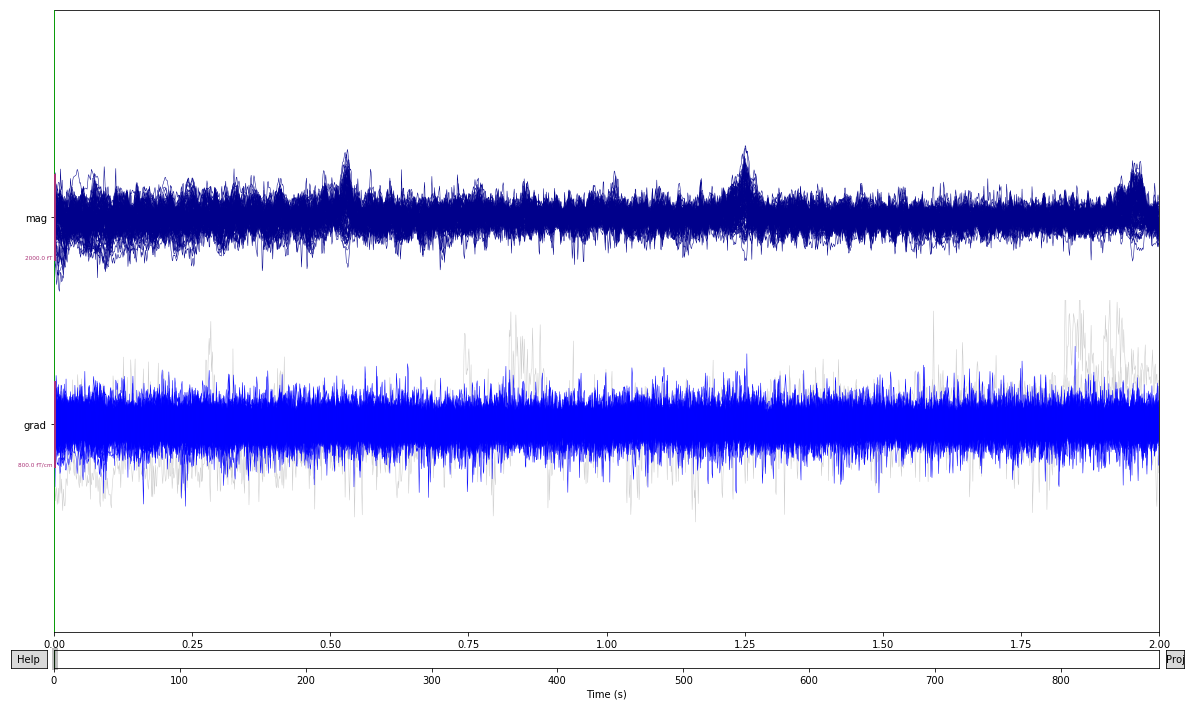

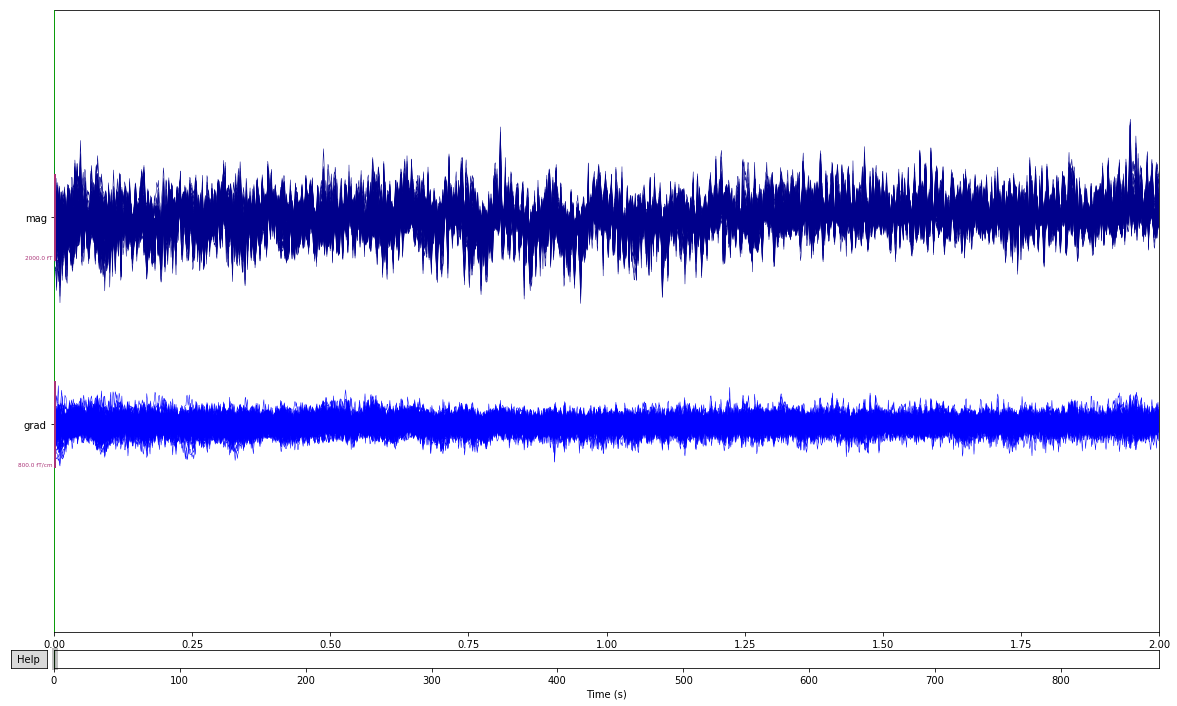

    Using multitaper spectrum estimation with 7 DPSS windows
Effective window size : 2.048 (s)


<ipython-input-51-079f532aaa41>:16: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  raw.plot_psd(picks = ["eeg"],fmin = 1,fmax = 40)


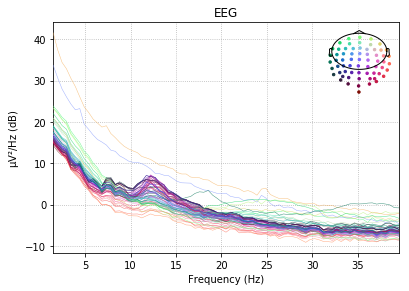

['EEG007', 'EEG043']
Interpolating bad channels
    Automatic origin fit: head of radius 74.7 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors


<ipython-input-52-613730eeb8fd>:77: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  raw_sss.interpolate_bads()


    Using multitaper spectrum estimation with 7 DPSS windows
Effective window size : 2.048 (s)


<ipython-input-51-079f532aaa41>:16: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  raw.plot_psd(picks = ["eeg"],fmin = 1,fmax = 40)


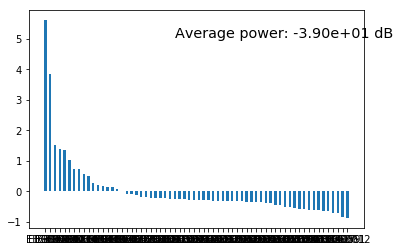

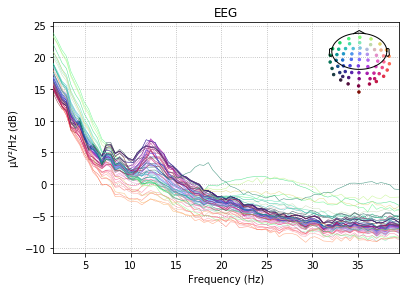

['EEG001', 'EEG002', 'EEG020']
Interpolating bad channels
    Automatic origin fit: head of radius 74.7 mm
Computing interpolation matrix from 61 sensor positions
Interpolating 3 sensors


<ipython-input-52-613730eeb8fd>:77: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  raw_sss.interpolate_bads()


    Using multitaper spectrum estimation with 7 DPSS windows
Effective window size : 2.048 (s)


<ipython-input-51-079f532aaa41>:16: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  raw.plot_psd(picks = ["eeg"],fmin = 1,fmax = 40)


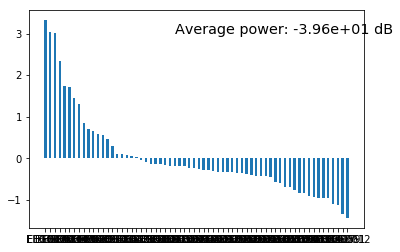

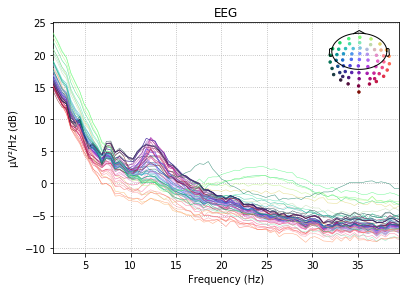

['EEG001', 'EEG020']
Interpolating bad channels
    Automatic origin fit: head of radius 74.7 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors


<ipython-input-52-613730eeb8fd>:77: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  raw_sss.interpolate_bads()


    Using multitaper spectrum estimation with 7 DPSS windows
Effective window size : 2.048 (s)


<ipython-input-51-079f532aaa41>:16: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  raw.plot_psd(picks = ["eeg"],fmin = 1,fmax = 40)


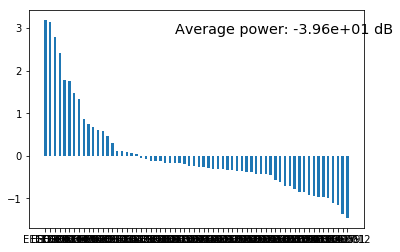

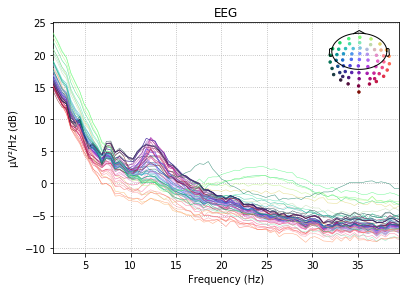

Overwriting existing file.
Writing /Users/bryan/Downloads/Peking_U/data/subj/sb_999/200923/out_file/sb_999_V1_DurR2_filt_tsss_raw.fif
Closing /Users/bryan/Downloads/Peking_U/data/subj/sb_999/200923/out_file/sb_999_V1_DurR2_filt_tsss_raw.fif [done]


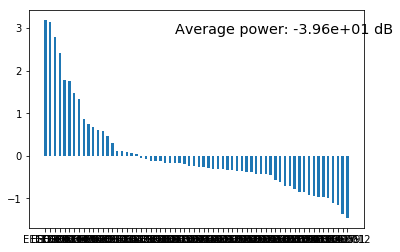

In [52]:
"""
===================================
01. Maxwell filter using MNE-python
===================================

The data are Maxwell filtered using tSSS/SSS.

It is critical to mark bad channels before Maxwell filtering.
""" 



def run_maxwell_filter(method=method, n_run=n_run,make_plot = True): #check n_run is correct!
    in_path = study_path   
    fname_out = op.join(out_path,
                            subject+'_V1_DurR%01d_filt_%s_raw.fif')
    
    stdout_obj = sys.stdout                 # store original stdout 
    sys.stdout = open(op.join(out_path,     # open log file
                              "01-maxwell_filtering_%s.txt" % subject),'w')
    
    print("Processing subject: %s" % subject)
    # Load the fine calibration file (which encodes site-specific information 
    # about sensor orientation and calibration) as well as a crosstalk 
    # compensation file (which reduces interference between Elekta’s co-located
    # magnetometer and paired gradiometer sensor units)
    fine_cal_file = cal_path + "sss_cal_SB.dat"
    crosstalk_file = cal_path + "ct_sparse_SB.fif"
    for run in range(1, n_run+1):
        print("  S %s - R %s" % (subject, run))
        raw_in = op.join(in_path, file_name +'%01d.fif' % run)
        raw = mne.io.read_raw_fif(raw_in,
                                  allow_maxshield=True,
                                  preload=True,
                                 verbose=True)
        # Detect bad channels
        raw_check = raw.copy().pick_types(exclude=()).filter(None, 40)
        auto_noisy_chs, auto_flat_chs = mne.preprocessing.find_bad_channels_maxwell(
            raw_check, 
            cross_talk=crosstalk_file, 
            calibration=fine_cal_file,
            verbose=True)
        print(auto_noisy_chs)
        print(auto_flat_chs)
        raw.info['bads'].extend(auto_noisy_chs + auto_flat_chs)
#         # Fix Elekta magnetometer coil types
#         raw.fix_mag_coil_types()
        # Perform tSSS/SSS and Maxwell filtering
        st_duration = 10 if method == 'tsss' else None  #move st_duration to config
        raw_sss = mne.preprocessing.maxwell_filter(
            raw,
            cross_talk=crosstalk_file,
            calibration=fine_cal_file,
            st_duration=st_duration,
            verbose=True)

        # Plot results
        if make_plot:
            fig = raw.copy().pick(['meg']).plot(duration=2,
                                   butterfly=True,
                                   title="Raw")
            fname_fig = op.join(out_path, 
                                subject+'_run_%02d-raw.png' % run)
            fig.savefig(fname_fig)
            plt.close()
            fig = raw_sss.copy().pick(['meg']).plot(duration=2,
                                       butterfly=True,
                                       title="Raw_%s" % method)
            fname_fig = op.join(out_path, 
                                subject+'_run_%02d-raw_%s.png' % (run,method))
            fig.savefig(fname_fig)
            plt.close()

        ## detect and interpolate EEG bad channels
        bads = find_bad_channels_eeg(raw_sss)
        k = 0
        while bads != []: 
            print(bads)
            raw_sss.info['bads'].extend(bads) 
            raw_sss.interpolate_bads()
            k += 1
            bads_tmp = find_bad_channels_eeg(raw_sss)
            if bads_tmp != bads:
                bads = bads_tmp
            else:
                bads = []
            if k > 5:
                raise ValueError("criteria for bad channel selection is inappropriate")
            
    
    
    
#         Save results    
        raw_out = fname_out % (run, method)
        raw_sss.save(raw_out, overwrite=True,)
        
    sys.stdout.close()      # close log file
    sys.stdout = stdout_obj # restore command prompt

##run function

run_maxwell_filter()

Processing subject: sb_999
  S sb_999 - R 1


<ipython-input-48-56de51aea342>:39: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  average=True) #fmax must not exceed


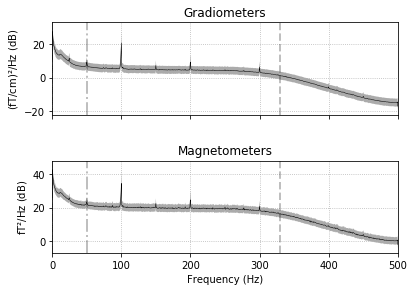

<ipython-input-48-56de51aea342>:42: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  average=True)


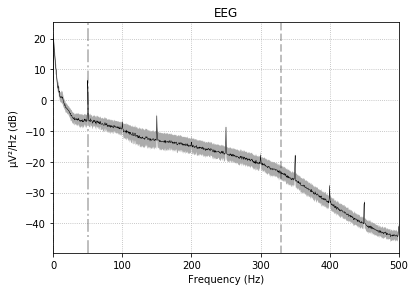

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 sec)

Resampling data to 100.0 Hz
1048 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  12  13  14  15  16  17  18  19
  20  21  22  24  25  26  27  28  29  30  31  32  34  37  38  39  40  41
  43  45  46  47  48  50  51  52  53  54  55  57  59  60  61  62  63  64
  65  66  67  68  70  71  72  73  74  75  76  78  83  86  96  97 101 102
 103 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 1

<ipython-input-48-56de51aea342>:82: RuntimeWarning: This filename (/Users/bryan/Downloads/Peking_U/data/subj/sb_999/200923/out_file/sb_999_V1_DurR1-eve_ds.fif) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst or _eve.txt
  mne.write_events(fname_events, events)


In [48]:
# %load 02-filtering_v1.py
"""
===========================
02. Filter using MNE-python
===========================

"""  # noqa: E501



#from library.config import study_path, meg_dir, l_freq, N_JOBS


def run_filter(l_freq = l_freq, h_freq = h_freq,method = method,
                n_run=n_run,make_plot = True):
    
    in_path = out_path
    maxfilter = method    
    raw_fname_in = op.join(in_path,
                           subject +'_V1_DurR%01d_filt_%s_raw.fif')
    raw_fname_out = op.join(out_path,
                            subject +'_V1_DurR%01d_filt_%s_bp%s-%s_ds%d_raw.fif')

    stdout_obj = sys.stdout                 # store original stdout 
    sys.stdout = open(op.join(out_path,     # open log file
                              "02_filtering_%s.txt" % subject),'w')
    print("Processing subject: %s" % subject)
    for run in range(1, n_run+1):
        print("  S %s - R %s" % (subject, run))
        raw_in = raw_fname_in % (run, maxfilter)
        raw = mne.io.read_raw_fif(raw_in, 
                                  preload=True, #preloading required by filter
                                  verbose='error')
    

#      #   Plot raw signal and power spectral density 
        if make_plot:    
            raw.plot_psd(fmax=500, picks=['meg'],
                         average=True) #fmax must not exceed 
                                                   #one half the sampling frequency of the data
            raw.plot_psd(fmax=500, picks=['eeg'],
                          average=True) 
        # Band-pass the data channels
        if any(f is not None for f in [l_freq, h_freq]):
            raw.filter(
                l_freq, h_freq,
#                 picks=channels,
                verbose=True)
            
        # # High-pass EOG to get reasonable thresholds in autoreject
        # picks_eog = mne.pick_types(raw.info, meg=False, eog=True)
        # if picks_eog.size > 0:
        #     raw.filter(
        #         l_freq, None,
        #         picks=picks_eog,
        #         l_trans_bandwidth='auto',
        #         filter_length='auto',
        #         phase='zero',
        #         fir_window='hann',
        #         fir_design='firwin',
        #         verbose=True)
        
        ### Downsample the data
        
        # must not downsample stims directly!!!
        # must output new events referring to the old ones and
        # save to keep all original events and their time according to downsampled signals
        if sfreq != 0:

            print("Resampling data to %.1f Hz" % sfreq)
            events = mne.find_events(raw,
                                 stim_channel='STI101',
                                 consecutive = False
                                 )
        
        
            raw, events = raw.load_data().resample(sfreq=sfreq,
                                     verbose=True, events=events) 

            fname_events = op.join(out_path,
                                   subject+'_V1_DurR%01d-eve_ds.fif' % run)
            mne.write_events(fname_events, events)

        raw_out = raw_fname_out % (run, maxfilter, l_freq, h_freq, sfreq)
        raw.save(raw_out, overwrite=True)
        
    sys.stdout.close()      # close log file
    sys.stdout = stdout_obj # restore command prompt



##run function
if band_pass_filter:
    run_filter()

Processing subject: sb_999
  S sb_999 - R 1
Opening raw data file /Users/bryan/Downloads/Peking_U/data/subj/sb_999/200923/run1.fif...
    Read a total of 13 projection items:
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
    Range : 11000 ... 449999 =     11.000 ...   449.999 secs
Ready.


<ipython-input-17-ac1754ec07a9>:30: RuntimeWarning: This filename (/Users/bryan/Downloads/Peking_U/data/subj/sb_999/200923/run1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  verbose=True)


1048 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  12  13  14  15  16  17  18  19
  20  21  22  24  25  26  27  28  29  30  31  32  34  37  38  39  40  41
  43  45  46  47  48  50  51  52  53  54  55  57  59  60  61  62  63  64
  65  66  67  68  70  71  72  73  74  75  76  78  83  86  96  97 101 102
 103 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 151 152 153 161 162 163 164 201 202 203 255]


<ipython-input-17-ac1754ec07a9>:41: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(events)


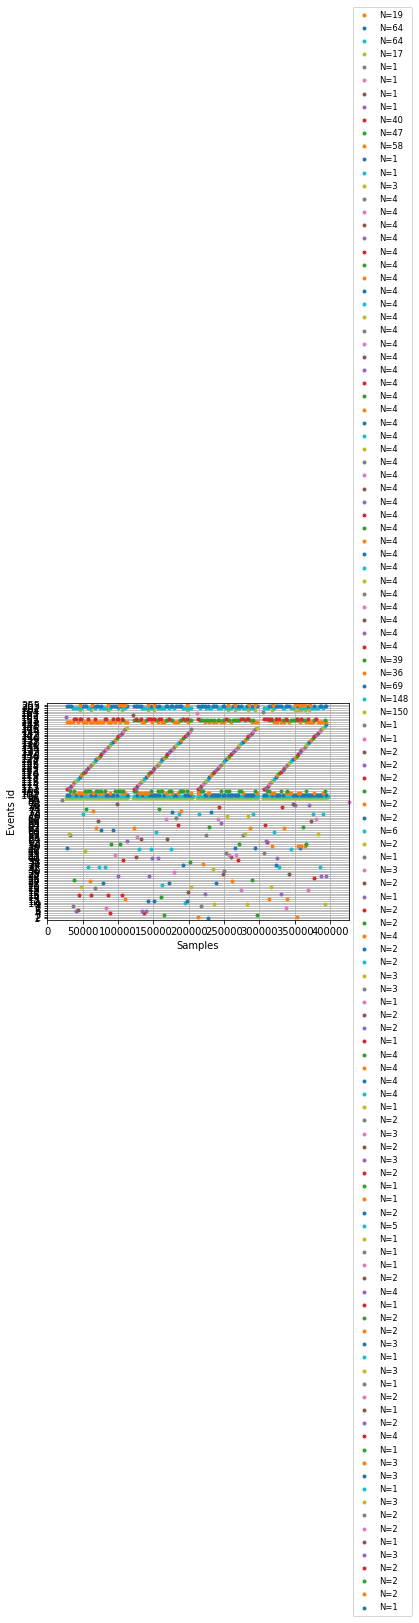

In [17]:
# %load 03-extract_events_v1.py
"""
============================================
03. Extract events from the stimulus channel
============================================

"""


def run_events(n_run= n_run,make_plot = True):
    in_path = study_path
    
    stdout_obj = sys.stdout                 # store original stdout 
    sys.stdout = open(op.join(out_path,     # open log file
                              "03-extract_events_%s.txt" % subject),'w')
    print("Processing subject: %s" % subject)
    for run in range(1, n_run+1):
        print("  S %s - R %s" % (subject, run))

        run_fname = op.join(in_path,
                            file_name+'%01d.fif' % run)

        raw = mne.io.read_raw_fif(run_fname,
                                  allow_maxshield=True,
                                  verbose=True)
        events = mne.find_events(raw,
                                 stim_channel='STI101',
                                 consecutive = False
                                 )

        fname_events = op.join(out_path,
                                   subject+'_V1_DurR%01d-eve.fif' % run)
        mne.write_events(fname_events, events)
        # Plot events and save as png
        if make_plot:
            fig = mne.viz.plot_events(events)
            
            fname_fig = op.join(out_path, subject+'_run_%02d-eve.png' % run)
            fig.savefig(fname_fig,
                        dpi=300)
            plt.close(fig)
    sys.stdout.close()      # close log file
    sys.stdout = stdout_obj # restore command prompt


##run function

run_events()

In [ ]:
# response = mne.find_events(raw,
#                             stim_channel='STI101',
#                             consecutive = False
#                                 )
# response = response[response[:,2] == 255]
# events = mne.find_events(raw,
#                          stim_channel='STI101',
#                          consecutive = 'True',
#                          min_duration=0.001001
#                         )
# events = events[events[:,2] != 255]

# events = np.concatenate([response,events],axis = 0)
# events = events[events[:,0].argsort(),:]


# fname_events = op.join(out_path,
#                            subject+'_V1_DurR%01d-eve.fif' % run)
# mne.write_events(fname_events, events)

Processing subject: sb_999
  Loading raw data
  Epoching
Not setting metadata
Not setting metadata
145 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 145 events and 251 original time points ...


<ipython-input-49-d0406c2b047b>:55: RuntimeWarning: This filename (/Users/bryan/Downloads/Peking_U/data/subj/sb_999/200923/out_file/sb_999_V1_DurR1-eve_ds.fif) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  verbose=True)


0 bad epochs dropped


d500  d1000  d1500
Total    58     47     40

<Info | 25 non-empty values
 acq_pars: ACQactiveGround 1 ACQch.BIO001.gain 2000 ACQch.BIO001.highpass ...
 bads: []
 ch_names: EOG001, BIO002, BIO003, EEG001, EEG002, EEG003, EEG004, EEG005, ...
 chs: 1 EOG, 2 BIO, 64 EEG, 102 MAG, 204 GRAD, 9 STIM
 custom_ref_applied: False
 description: TRIUX system at PKU Meg Lab
 dev_head_t: MEG device -> head transform
 dig: 111 items (3 Cardinal, 4 HPI, 65 EEG, 39 Extra)
 events: 1 item (list)
 experimenter: pkumeg
 file_id: 4 items (dict)
 gantry_angle: 68.0
 highpass: 1.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 3 items (dict)
 line_freq: 50.0
 lowpass: 40.0 Hz
 meas_date: 2020-09-23 04:37:01 UTC
 meas_id: 4 items (dict)
 nchan: 382
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: huanluo
 projs: Average EEG reference: on
 sfreq: 100.0 Hz
 subject_info: 6 items (dict)
>
  Writing to disk
Overwriting existing file.
Loading data for 1 events and 251 original time points ...
Loading data for 145 ev

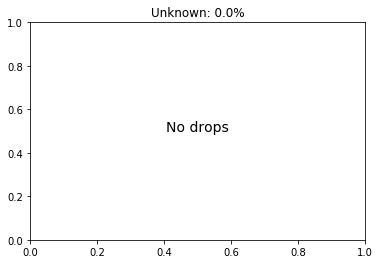

In [49]:
# %load 04-make_epochs_V1.py
"""
====================
04. Make epochs
====================

"""


###############################################################################
# We define the events and the onset and offset of the epochs


### set your own event ids for different grouping
#events_id = {'d500':151,'d1000':152,'d1500':153,'rTarget':201,'rnTarget':202,'irre':203}

events_id = {'d500':151,'d1000':152,'d1500':153}


###############################################################################
# Now we define a function to extract epochs for one subject
def run_epochs(band_pass_filter = band_pass_filter,
               sfreq = sfreq, n_run= n_run,make_plot = True):

    stdout_obj = sys.stdout                 # store original stdout 
    sys.stdout = open(op.join(out_path,     # open log file
                              "04-make_epochs_%s.txt" % subject),'w')
    print("Processing subject: %s" % subject)
    
    # map to correct subject for bad channels
    #mapping = map_subjects[subject_id]
    raw_list = list()
    events_list = list()
    print("  Loading raw data")
    for run in range(1, n_run+1):

        
        if band_pass_filter:
            raw_fname_out = op.join(out_path,
                                subject +'_V1_DurR%01d_filt_%s_bp%s-%s_ds%d_raw.fif')
            run_fname = raw_fname_out % (run, method, l_freq, h_freq, sfreq)
        else:
            run_fname = op.join(out_path,
                            subject +'_V1_DurR%01d_filt_tsss_raw.fif' % run)

        raw = mne.io.read_raw_fif(run_fname,
                                  preload=True,
                                  verbose='error')

        if (sfreq != 0) and (band_pass_filter):
            events = mne.read_events(op.join(out_path,
                                                 subject +'_V1_DurR%01d-eve_ds.fif' % run),
                                         verbose=True)
        else:
            events = mne.read_events(op.join(out_path,
                                             subject +'_V1_DurR%01d-eve.fif' % run),
                                     verbose=True)

            
        events_list.append(events)
        
        
        raw_list.append(raw)

    raw, events = mne.concatenate_raws(raw_list,
                                       events_list=events_list)
    
    raw.set_eeg_reference(projection=True)
    del raw_list

        
    # Epoch the data
    print('  Epoching')
    reject = dict(grad=4000e-13,    # T / m (gradiometers)
                  mag=4e-12,        # T (magnetometers)
                  eeg=200e-6,        # V (EEG channels)
#                 eog=150e-6        # V (EOG channels)
                  )
    picks = mne.pick_types(raw.info,
                           meg = True,
                           eeg = True,
                           stim = True,
                           eog = True,
                           ecg = True,
                           )
    epochs = mne.Epochs(raw,
                        events, events_id,
                        tmin, tmax,
                        proj=True,
                        picks = picks,
#                       decim=3,      #Amount to decimate the data during display for speed purposes.
                                      #should only decimate if the data are sufficiently low-passed, 
                                      #otherwise aliasing can occur
                                      #don't need if already downsampled
                        reject=reject,
                        verbose=True)

    if make_plot:
#         epochs.plot(picks='meg',
#                     title='meg')
#         epochs.plot_image(combine='gfp',
#                            sigma=1.5) 
        #combine
        #one of ‘mean’, ‘median’, ‘std’ (standard deviation) or ‘gfp’ (global field power)
        #sigma
        #The standard deviation of a Gaussian smoothing window applied along the epochs axis of the image.
        #If 0, no smoothing is applied. Defaults to 0
        epochs.drop_bad()
        epochs.plot_drop_log()
        
        #counting the number of epochs defined by different events
        num = {}
        for key in events_id:
            num[key] = len(epochs[key])
        df = pd.DataFrame(num,index = ["Total"])
        display(df)
        
        
        print(epochs.info)
    

    del raw
    print('  Writing to disk')
    epochs.save(op.join(out_path,
                        subject+'_V1_DurRall_filt_tsss_epo.fif'),
                    overwrite=True)
    
    sys.stdout.close()      # close log file
    sys.stdout = stdout_obj # restore command prompt



##run function

run_epochs()


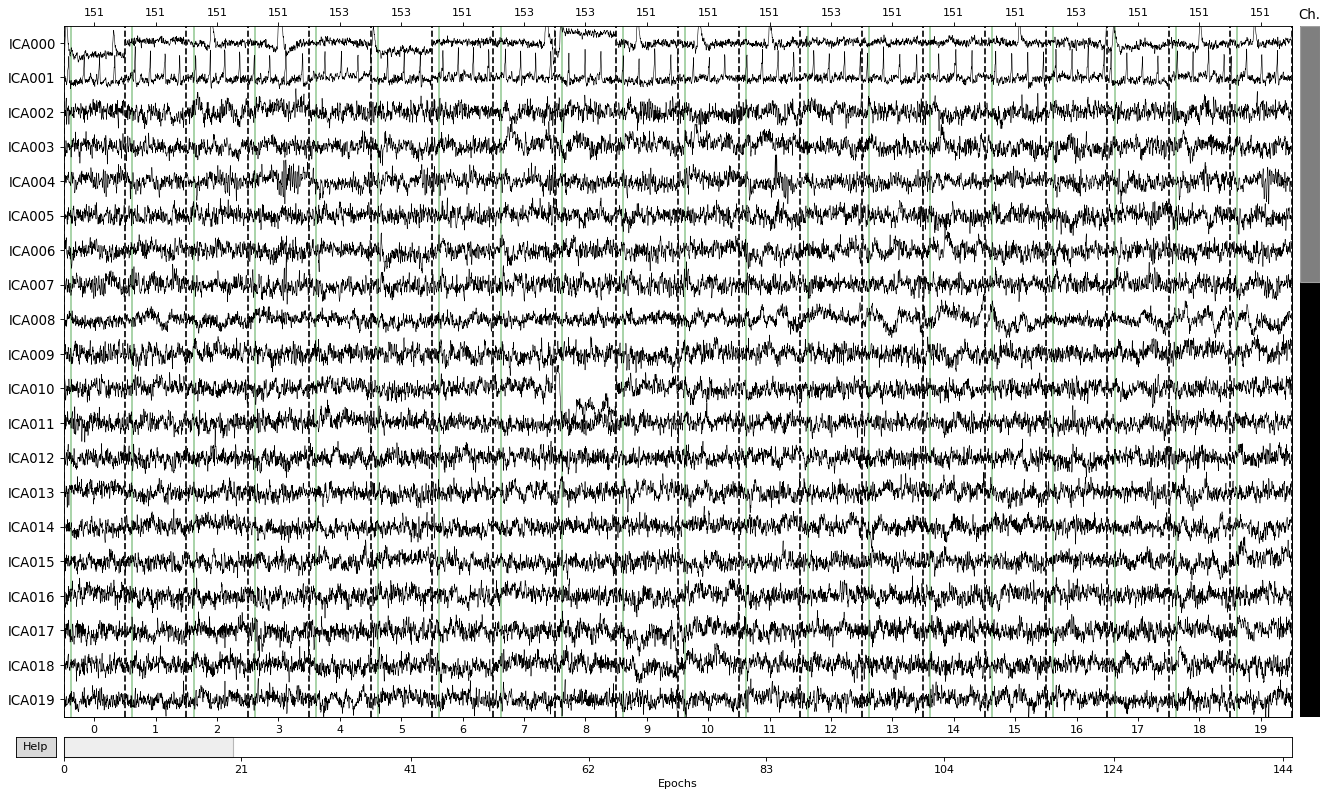

<ipython-input-17-be45b943a289>:48: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  ica.plot_components(title=title)


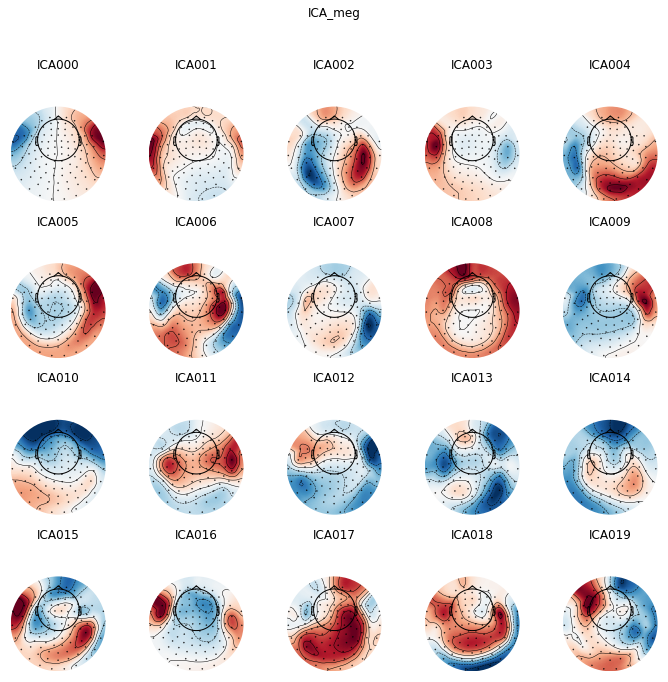

<ipython-input-17-be45b943a289>:48: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  ica.plot_components(title=title)


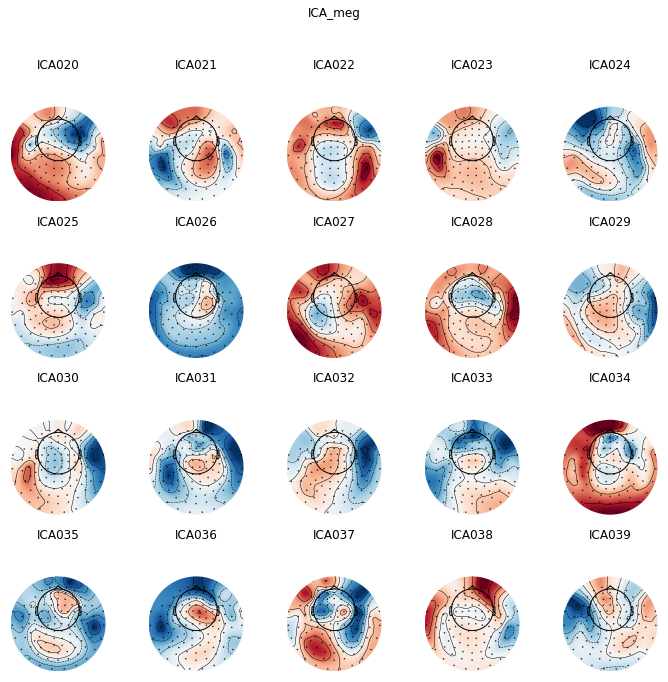

<ipython-input-17-be45b943a289>:48: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  ica.plot_components(title=title)


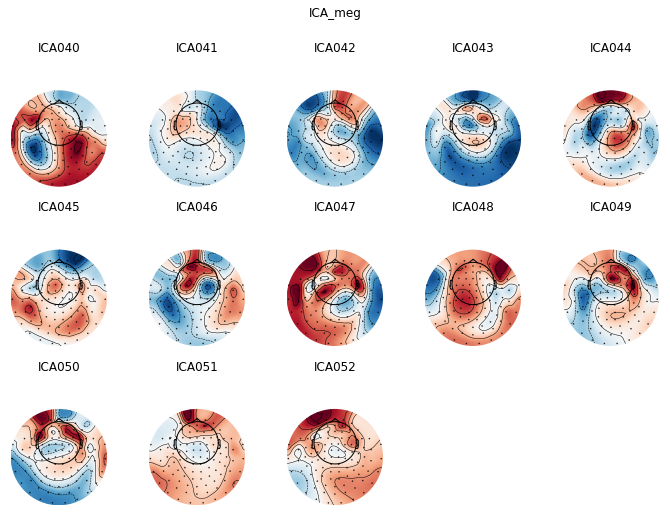

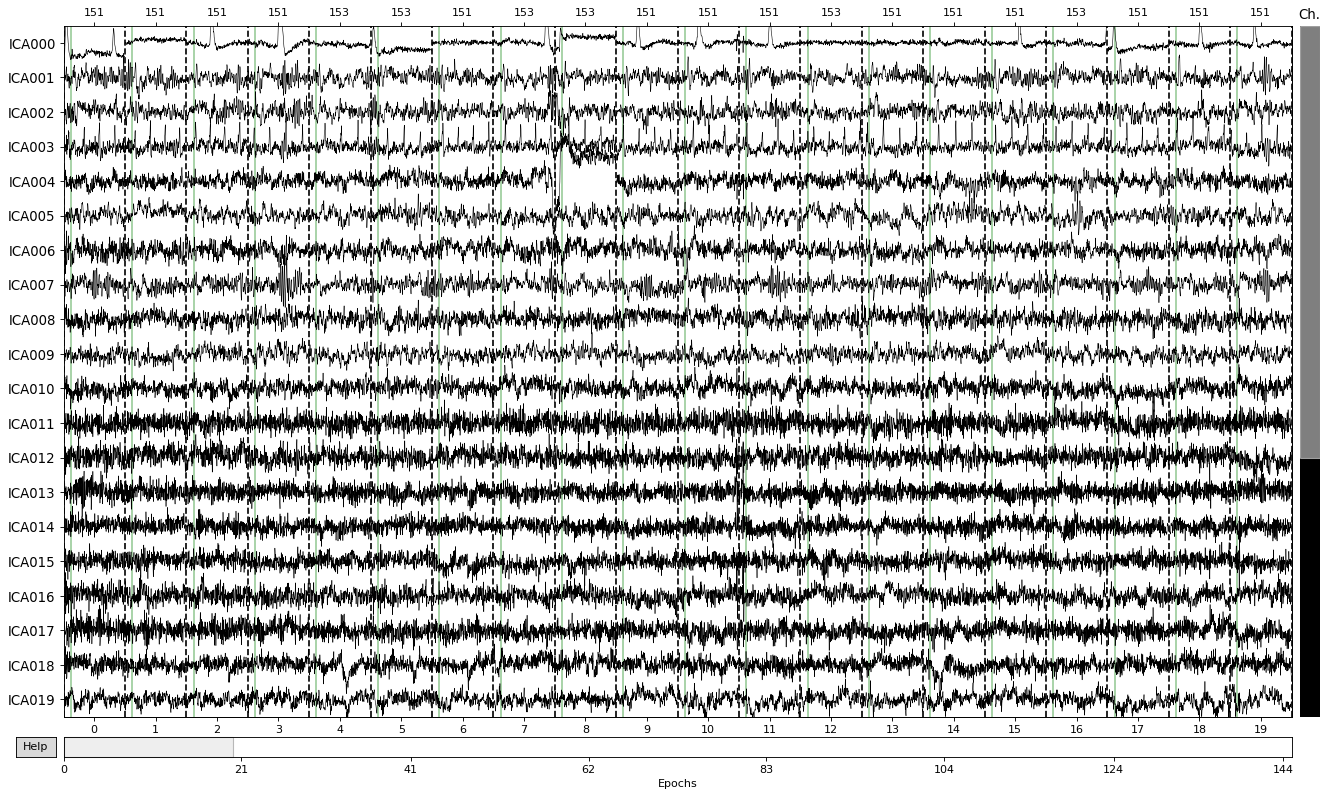

<ipython-input-17-be45b943a289>:48: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  ica.plot_components(title=title)
<ipython-input-17-be45b943a289>:48: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  ica.plot_components(title=title)


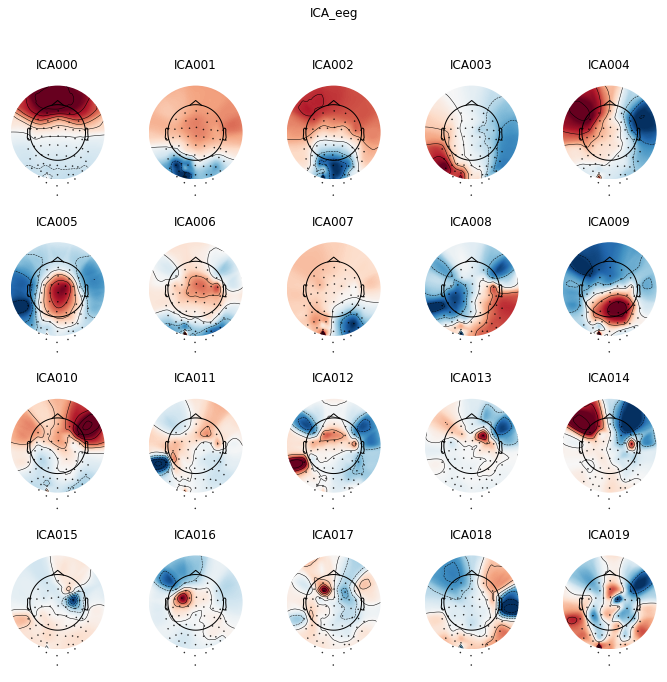

<ipython-input-17-be45b943a289>:48: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  ica.plot_components(title=title)
<ipython-input-17-be45b943a289>:48: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  ica.plot_components(title=title)


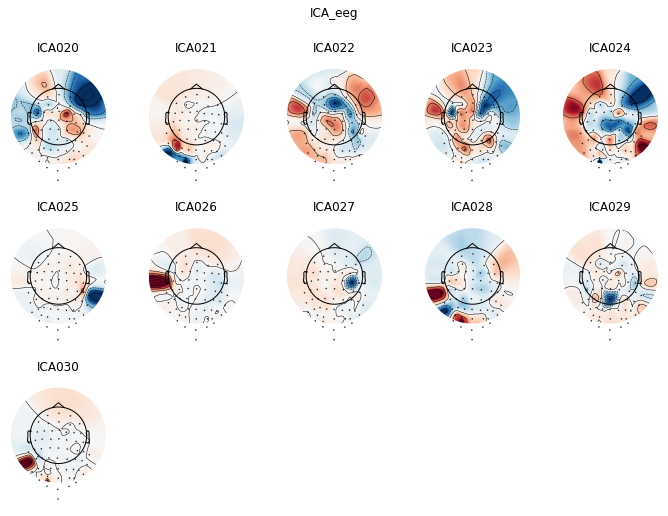

In [17]:
# %load 05-run_ica_v1.py
"""
===========
05. Run ICA
===========

"""




def run_ica(n_components = n_components, random_state = random_state,
            n_run= n_run,make_plot = make_plot):
    

    stdout_obj = sys.stdout                 # store original stdout 
    sys.stdout = open(op.join(out_path,     # open log file
                              "05-run_ica_%s.txt" % subject),'w')
    print("Processing subject: %s" % subject)
    epochs_fname = op.join(out_path,
                           subject+'_V1_DurRall_filt_tsss_epo.fif')
    epochs = mne.read_epochs(epochs_fname,
                             verbose = True)

    # Compute ICA on MEG and EEG




    for ch_type in ['meg','eeg']:
        print('\n')
        print("###############################################################")
        print('  Running ICA for ' + ch_type)
        print("###############################################################")
        ica = ICA(method='fastica',
                  random_state=random_state,
                  n_components=n_components,
                  verbose=True)

        ica.fit(epochs,
                picks=ch_type,
             #   decim=10,
                verbose=True)
        # Plot the time series of the ICs
        if make_plot:
            title = ('ICA_%s'%(ch_type))
            fig = ica.plot_sources(epochs,title=title) 
            ica.plot_components(title=title)

#             fname_fig = op.join(out_path, 
#                                 subject + "_"+ ch_type + '_ICA_components&sources.png')
#             fig.savefig(fname_fig)
            plt.close(fig)
  


        print('    Fit %d components (explaining at least %0.1f%% of the variance)'
              % (ica.n_components_, 100 * n_components))
        ica_fname = op.join(out_path,
                       subject+'_V1_DurRall_filt_tsss_epo-%03s_ica.fif' % ch_type)
        ica.save(ica_fname)
        
        
    sys.stdout.close()      # close log file
    sys.stdout = stdout_obj # restore command prompt



##run function

run_ica()

In [18]:
###Manually select ica 

##MEG
EOG_meg_ica = [0]
ECG_meg_ica = [1]
##EEG
EOG_eeg_ica = [0]
ECG_eeg_ica = [3]

<ipython-input-19-b50a178edd04>:63: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  ica.plot_properties(epochs, picks=EOG_meg_ica)


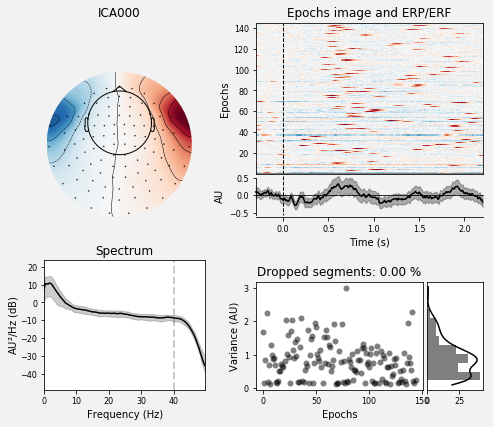

<ipython-input-19-b50a178edd04>:68: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  ica.plot_properties(epochs, picks=ECG_meg_ica)


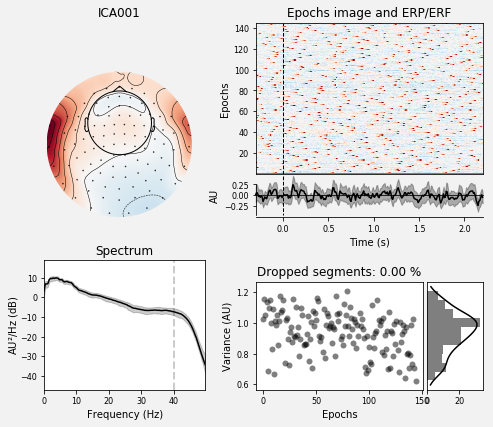

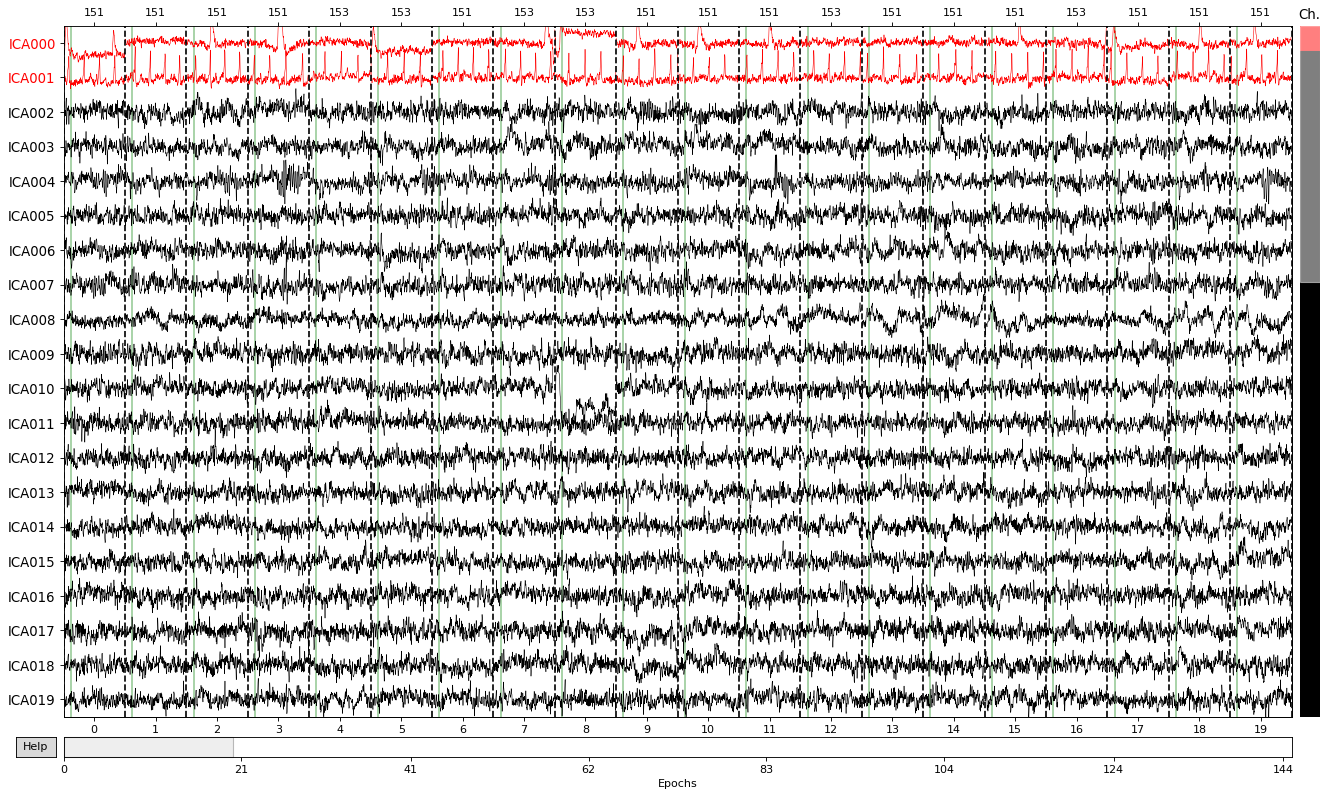

<ipython-input-19-b50a178edd04>:94: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  ica.plot_properties(epochs, picks=EOG_eeg_ica)
<ipython-input-19-b50a178edd04>:94: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  ica.plot_properties(epochs, picks=EOG_eeg_ica)


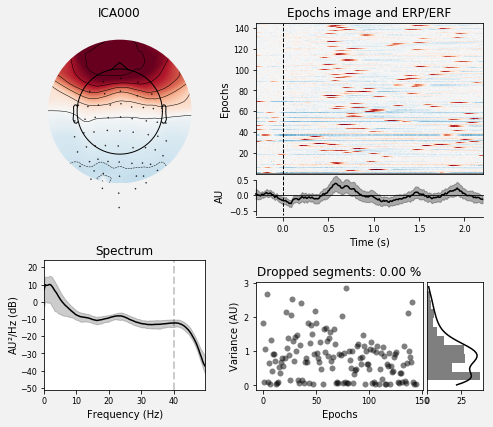

<ipython-input-19-b50a178edd04>:99: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  ica.plot_properties(epochs, picks=ECG_eeg_ica)
<ipython-input-19-b50a178edd04>:99: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  ica.plot_properties(epochs, picks=ECG_eeg_ica)


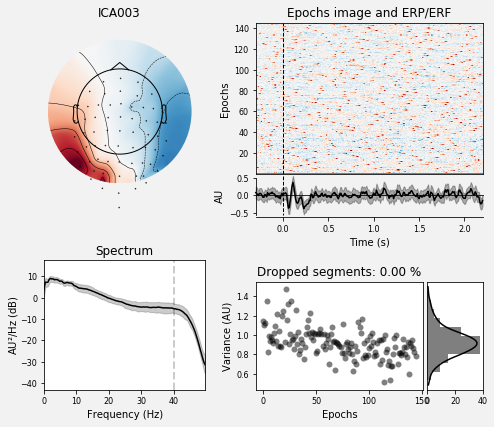

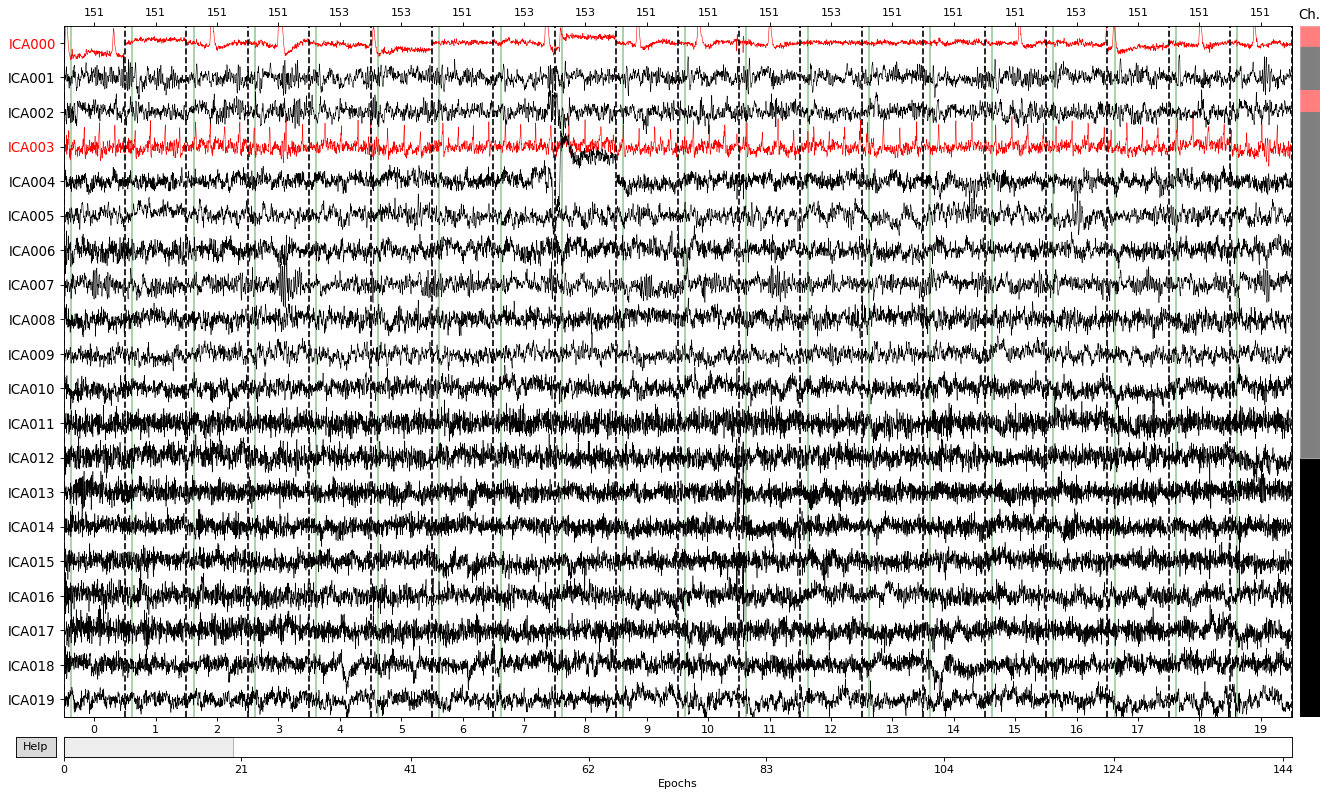

<ipython-input-19-b50a178edd04>:105: RuntimeWarning: This filename (/Users/bryan/Downloads/Peking_U/data/subj/sb_999/200923/out_file/sb_999_V1_DurRall_filt_tsss_epo_cleaned.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(fname_out,overwrite=True)


In [19]:
"""
===============
06. Apply ICA
===============

Blinks and ECG artifacts are automatically detected and the corresponding ICA
components are removed from the data.
This relies on the ICAs computed in 05-run_ica.py
!! If you manually add components to remove (config.rejcomps_man),
make sure you did not re-run the ICA in the meantime. Otherwise (especially if
the random state was not set, or you used a different machine, the component
order might differ).

"""



def apply_ica(EOG_meg_ica = EOG_meg_ica,
              ECG_meg_ica = ECG_meg_ica,
              EOG_eeg_ica = EOG_eeg_ica,
              ECG_eeg_ica = ECG_eeg_ica,
              make_plot = make_plot
              ):




    print("Processing subject: %s" % subject)

    # Load epochs
    epochs_fname = op.join(out_path,
                       subject+'_V1_DurRall_filt_tsss_epo.fif')
    epochs = mne.read_epochs(epochs_fname,
                             preload=True,
                             verbose='error')
    fname_out = op.join(out_path,
                       subject+'_V1_DurRall_filt_tsss_epo_cleaned.fif')

   
    if (EOG_meg_ica != []) or (ECG_meg_ica != []):
    
        ch_type = 'meg'
       
        ica_fname = op.join(out_path,
                            subject+'_V1_DurRall_filt_tsss_epo-%03s_ica.fif' % ch_type)
        ica = read_ica(ica_fname)




        ica.exclude.extend(EOG_meg_ica)
        ica.exclude.extend(ECG_meg_ica)
        
        if make_plot:
            print('\n')
            print("###############################################################")
            print('  Apply ICA for ' + ch_type)
            print("###############################################################")
            if EOG_meg_ica != []:

                print("plot diagnostics for EOG components:")

                ica.plot_properties(epochs, picks=EOG_meg_ica)
            if ECG_meg_ica != []:

                print("plot diagnostics for ECG components:")

                ica.plot_properties(epochs, picks=ECG_meg_ica)

           # plot ICs applied to raw data, with ECG/EOG matches highlighted
            ica.plot_sources(epochs)
        epochs = ica.apply(epochs)
    
    if (EOG_eeg_ica != []) or (ECG_eeg_ica != []):
        ch_type = 'eeg'

        ica_fname = op.join(out_path,
                            subject+'_V1_DurRall_filt_tsss_epo-%03s_ica.fif' % ch_type)
        ica = read_ica(ica_fname)

       

        ica.exclude.extend(EOG_eeg_ica)
        ica.exclude.extend(ECG_eeg_ica)

        if make_plot:
            print("###############################################################")
            print('  Apply ICA for ' + ch_type)
            print("###############################################################")
            if EOG_eeg_ica != []:

                print("plot diagnostics for EOG components:")

                ica.plot_properties(epochs, picks=EOG_eeg_ica)
            if ECG_eeg_ica != []:

                print("plot diagnostics for ECG components:")

                ica.plot_properties(epochs, picks=ECG_eeg_ica)

           # plot ICs applied to raw data, with ECG/EOG matches highlighted
            ica.plot_sources(epochs)
        epochs = ica.apply(epochs)

    epochs.save(fname_out,overwrite=True)
    del ica

    # Plot
#     if make_plot:
#         epochs.plot_image(combine='gfp',
#                           sigma=2.)


        
##run function

apply_ica()

<ipython-input-20-16b61d521a0c>:22: RuntimeWarning: This filename (/Users/bryan/Downloads/Peking_U/data/subj/sb_999/200923/out_file/sb_999_V1_DurRall_filt_tsss_epo_cleaned.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  verbose=True)
<ipython-input-20-16b61d521a0c>:49: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))
<ipython-input-20-16b61d521a0c>:49: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))
<ipython-input-20-16b61d521a0c>:49: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))


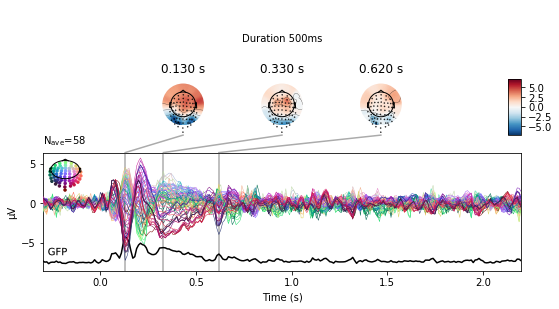

<ipython-input-20-16b61d521a0c>:49: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))
<ipython-input-20-16b61d521a0c>:49: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))


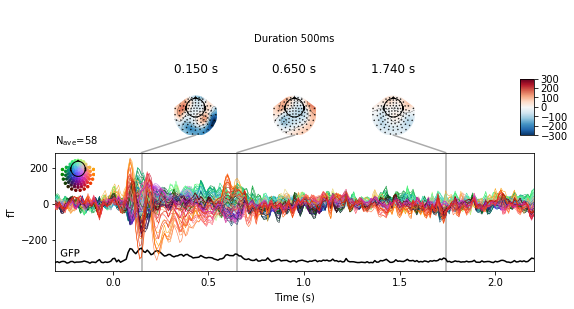

<ipython-input-20-16b61d521a0c>:49: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))
<ipython-input-20-16b61d521a0c>:49: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))


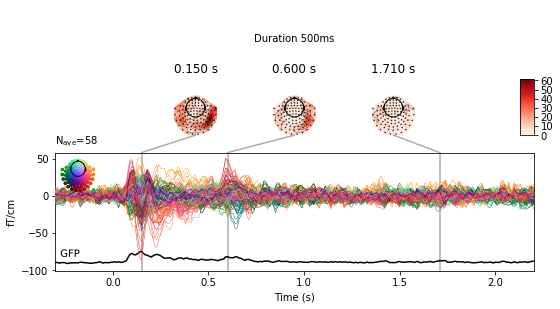

<ipython-input-20-16b61d521a0c>:53: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))
<ipython-input-20-16b61d521a0c>:53: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))
<ipython-input-20-16b61d521a0c>:53: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))


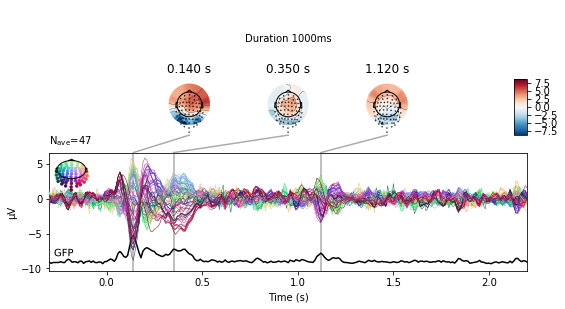

<ipython-input-20-16b61d521a0c>:53: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))
<ipython-input-20-16b61d521a0c>:53: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))


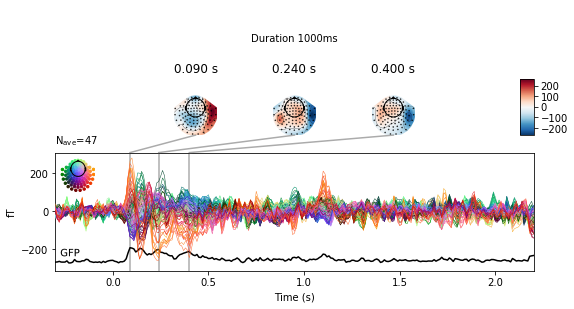

<ipython-input-20-16b61d521a0c>:53: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))
<ipython-input-20-16b61d521a0c>:53: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))


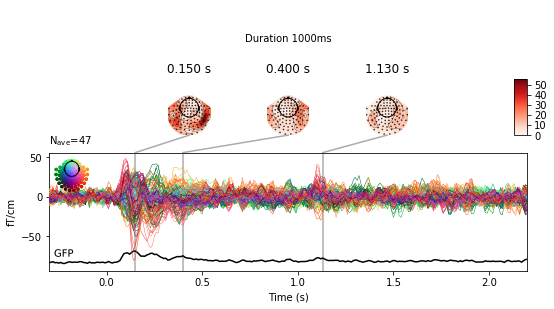

<ipython-input-20-16b61d521a0c>:57: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))
<ipython-input-20-16b61d521a0c>:57: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))
<ipython-input-20-16b61d521a0c>:57: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))


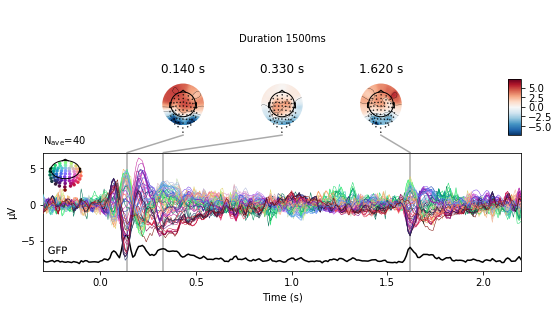

<ipython-input-20-16b61d521a0c>:57: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))
<ipython-input-20-16b61d521a0c>:57: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))


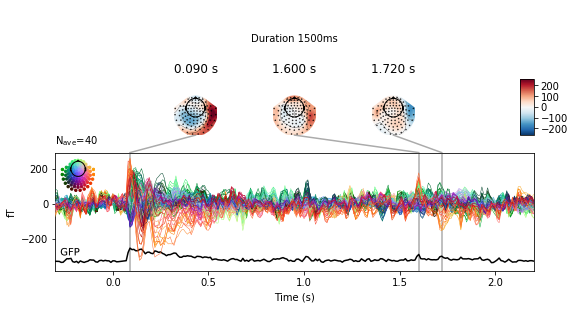

<ipython-input-20-16b61d521a0c>:57: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))
<ipython-input-20-16b61d521a0c>:57: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))


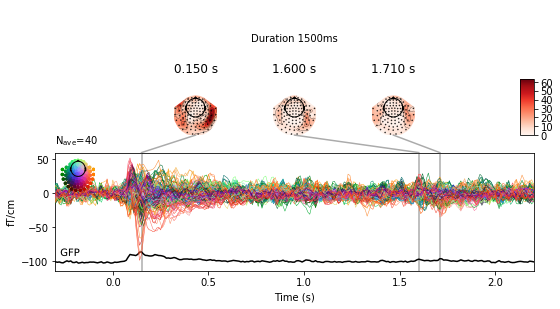

<ipython-input-20-16b61d521a0c>:61: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))
<ipython-input-20-16b61d521a0c>:61: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))
<ipython-input-20-16b61d521a0c>:61: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))


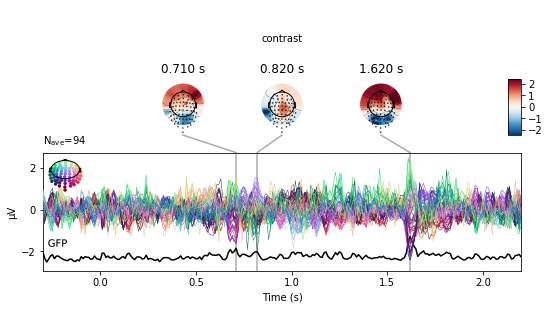

<ipython-input-20-16b61d521a0c>:61: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))
<ipython-input-20-16b61d521a0c>:61: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))


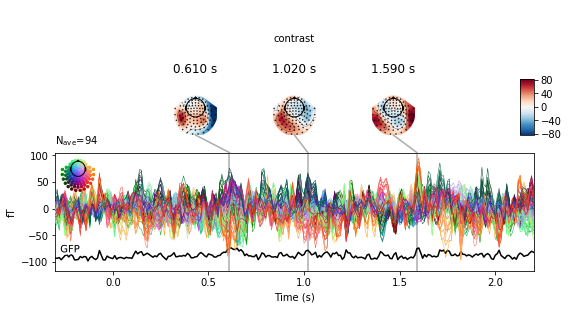

<ipython-input-20-16b61d521a0c>:61: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))
<ipython-input-20-16b61d521a0c>:61: RuntimeWarning: (X, Y) fit (-0.3, 43.6) more than 20 mm from head frame origin
  topomap_args = dict(time_unit='s'))


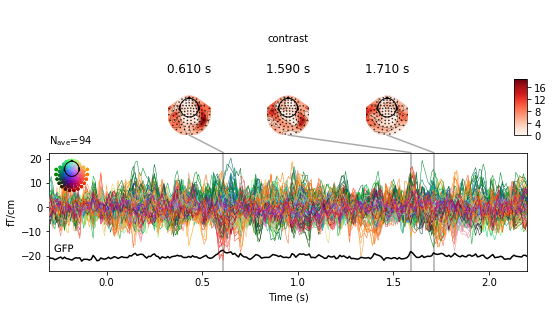

In [20]:
"""
===============
07. Evoked data
===============

"""

def run_evoked(make_plot = True):


#     stdout_obj = sys.stdout                 # store original stdout 
#     sys.stdout = open(op.join(out_path,     # open log file
#                               "07-make_evoked_%s.txt" % subject),'w')
    print("Processing subject: %s" % subject)
    fname_epo = op.join(out_path,
                        subject+'_V1_DurRall_filt_tsss_epo_cleaned.fif') #_MEEG_V1_DurRall_filt_tsss_epo_cleaned
#     fname_epo = op.join(out_path,
#                         subject+'_V1_DurRall_filt_tsss_epo.fif')
    print('  Creating evoked datasets')
    epochs = mne.read_epochs(fname_epo,
                             preload=True,
                             verbose=True)
    
    # Evoked responses
    
    ### Averaging over groups
    # select your own group based on the defined event id
    print(epochs.info)
    evoked_d500=epochs['d500'].average(method='mean')
    evoked_d1000=epochs['d1000'].average(method='mean')
    evoked_d1500=epochs['d1500'].average(method='mean')
    # Simplify comment
    evoked_d500.comment = 'Duration 500ms'
    evoked_d1000.comment = 'Duration 1000ms'
    evoked_d1500.comment = 'Duration 1500ms'
    
    # Contrast conditions
    contrast = mne.combine_evoked([evoked_d1500,-evoked_d500],
                                  weights=[0.5, 0.5,]
                                  )
    contrast.comment = 'contrast'

    
    # Plot evoked responses
    if make_plot:
        evoked_d500.apply_baseline(baseline=(-0.3, 0))
        evoked_d500.plot_joint(title=evoked_d500.comment,
                                 ts_args = dict(gfp=True, time_unit='s'),
                                 topomap_args = dict(time_unit='s'))
        evoked_d1000.apply_baseline(baseline=(-0.3, 0))
        evoked_d1000.plot_joint(title=evoked_d1000.comment,
                                 ts_args = dict(gfp=True, time_unit='s'),
                                 topomap_args = dict(time_unit='s'))
        evoked_d1500.apply_baseline(baseline=(-0.3, 0))
        evoked_d1500.plot_joint(title=evoked_d1500.comment,
                                 ts_args = dict(gfp=True, time_unit='s'),
                                 topomap_args = dict(time_unit='s'))
     
        contrast.plot_joint(title=contrast.comment,
                                 ts_args = dict(gfp=True, time_unit='s'),
                                 topomap_args = dict(time_unit='s'))
   
 
##run function

run_evoked()